# Billboard Hot 100:  Data Analysis

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; In this notebook, we'll take a look at the Billboard Hot 100 list from the year 2000.  After some exploratory data analysis, we will do a hypothesis testing on our findings.   First, let's do our imports and get our data set loaded:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
from scipy.stats import gaussian_kde

%matplotlib inline

### Import data

In [2]:
music = pd.read_csv('./assets/billboard.csv')
music.head(2)

,year,artist.inverted,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,...,x67th.week,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week
0,2000,Destiny's Child,Independent Women Part I,"3,38,00 AM",Rock,"September 23, 2000","November 18, 2000",78,63,49,...,*,*,*,*,*,*,*,*,*,*
1,2000,Santana,"Maria, Maria","4,18,00 AM",Rock,"February 12, 2000","April 8, 2000",15,8,6,...,*,*,*,*,*,*,*,*,*,*


In [3]:
music.dtypes[0:8]

year                int64
artist.inverted    object
track              object
time               object
genre              object
date.entered       object
date.peaked        object
x1st.week           int64
dtype: object

In [4]:
## remove 'year' column if all values are the same
try:
    if len(set(music['year'])) == 1:
        music.drop(['year'], axis = 1, inplace = True)
    else:
        print len(set(music['year']))
except: 
    pass

Find any song names which appear twice:

In [5]:
for i in range(len(music['track'].value_counts(ascending = False))):
    if music['track'].value_counts(ascending = False)[i] > 1:
        print music[music['track'] == music['track'].value_counts(ascending = False).index[i]]\
            [['artist.inverted', 'track']]

    artist.inverted             track
118   Jones, Donell  Where I Wanna Be
305   Sheist, Shade  Where I Wanna Be


In [6]:
music['genre'].value_counts()

Rock           103
Country         74
Rap             58
Rock'n'roll     34
R&B             13
R & B           10
Pop              9
Latin            9
Electronica      4
Gospel           1
Jazz             1
Reggae           1
Name: genre, dtype: int64

Check out singletons:

In [7]:
music[(music['genre'] == 'Gospel') |\
      (music['genre'] == 'Jazz') |\
      (music['genre'] == 'Reggae')][['artist.inverted', 'track', 'genre']]

,artist.inverted,track,genre
49,Kenny G,Auld Lang Syne (The Millenium Mix),Jazz
189,Beenie Man,Girls Dem Sugar,Reggae
200,"Adams, Yolanda",Open My Heart,Gospel


Let's get rid:

In [8]:
music = music[(music['genre'] != 'Gospel') & (music['genre'] != 'Jazz') & (music['genre'] != 'Reggae')]

In [9]:
music['genre'] = music['genre'].apply(lambda x: x.replace('R & B', 'R&B'))
music['genre'] = music['genre'].astype('category')
music['genre'].value_counts()

Rock           103
Country         74
Rap             58
Rock'n'roll     34
R&B             23
Pop              9
Latin            9
Electronica      4
Name: genre, dtype: int64

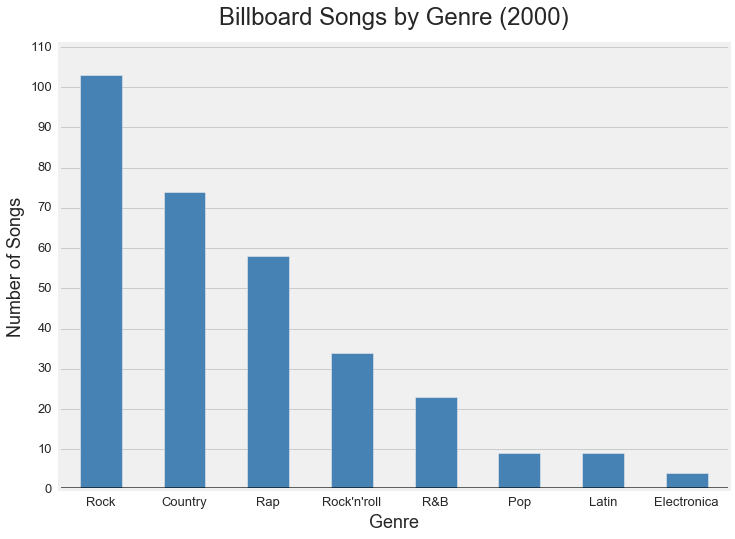

In [10]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

y = pd.DataFrame(music['genre'].value_counts())

y['genre'].plot.bar(color = 'steelblue')

plt.title('Billboard Songs by Genre (2000)', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Number of Songs', fontsize = 18)
plt.yticks(range(0, 120, 10), fontsize = 13)
plt.ylim([0, 111])

# x label
plt.xlabel('Genre', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=0, fontsize = 13)

plt.grid(which = 'major', axis = 'x')


plt.show()

Now, let's fix the artist names:

In [11]:
def fix_name(artist):
    try:
        name = artist.split(', ')
        new_name = "%s" %name[1] + " %s" %name[0]
    except:
        new_name = artist
    return new_name

In [12]:
music['artist.inverted'] = music['artist.inverted'].apply(lambda x: fix_name(x))
music = music.rename(columns={'artist.inverted': 'artist'})

Let's make a column for entering chart position, which we'll use it to calculate time to peak position:

In [13]:
music['entering_position'] = music['x1st.week'].apply(lambda x: float(x))

Clean column of track lengths:

In [14]:
music['time'].max() 

'7,35,00 AM'

In [15]:
music['time'] = music['time'].apply(lambda x: x.replace(',00 AM', ''))

In [16]:
def get_sec(s):
    try:
        time = s.split(',')
        new_s = float(int(time[0]) * 60 + int(time[1]))
    except:
        new_s = s
    return new_s

In [17]:
music['time'] = music['time'].apply(lambda x: get_sec(x))
music[['artist', 'track', 'time', 'genre']].sort_values(by = 'time', ascending = False).head()
## longest songs:

,artist,track,time,genre
128,Enrique Iglesias,Rhythm Divine,455.0,Latin
100,D'Angelo,Untitled (How Does It Feel),430.0,R&B
109,Alice Deejay,Better Off Alone,410.0,Electronica
118,Donell Jones,Where I Wanna Be,382.0,Rock
229,Kelly Price,As We Lay,380.0,Rock'n'roll


Let's convert two date columns to datetime objects and difference them to get a time elapsed:

In [18]:
music['date.entered'] = music['date.entered'].apply(lambda x: pd.to_datetime(x))
music['date.peaked'] = music['date.peaked'].apply(lambda x: pd.to_datetime(x))

music = music.rename(columns = {
        'date.entered' : 'date_entered', 
        'date.peaked' : 'date_peaked'
    })

In [19]:
music['weeks_to_peak'] = ((music['date_peaked']-music['date_entered'])/7)\
                                                            .apply(lambda x: float(x.days))
music['weeks_to_peak'].head()

0     8.0
1     8.0
2    14.0
3     5.0
4    10.0
Name: weeks_to_peak, dtype: float64

### Visualize Data

Find peak position attained by each track:

In [20]:
music_weeks = music.drop(['artist', 'track', 'genre', 'time', 'entering_position', \
                    'weeks_to_peak', 'date_entered', 'date_peaked'], axis=1, inplace=False)
music_weeks = music_weeks.replace('*', np.nan)    
music_weeks = music_weeks.applymap(lambda x: float(x))

peak_pos = []
for i in range(len(music_weeks)):
    pos = float(music_weeks.iloc[i, :].min())
    peak_pos.append(pos)

music['peak_position'] = peak_pos
del music_weeks, peak_pos

In [21]:
music = music[['artist', 'track', 'genre', 'time', 'entering_position', 'weeks_to_peak', \
               'peak_position', 'date_entered', 'date_peaked']]

Which songs peaked at number 1?

In [22]:
music[['artist', 'track', 'genre', 'peak_position']].sort_values('peak_position', axis=0, \
                ascending=True, inplace=False, kind='quicksort', na_position='last').head()

,artist,track,genre,peak_position
0,Destiny's Child,Independent Women Part I,Rock,1.0
16,Mariah Carey,Thank God I Found You,Rock,1.0
15,matchbox twenty,Bent,Rock,1.0
14,Aaliyah,Try Again,Rock'n'roll,1.0
13,Creed,With Arms Wide Open,Rock'n'roll,1.0


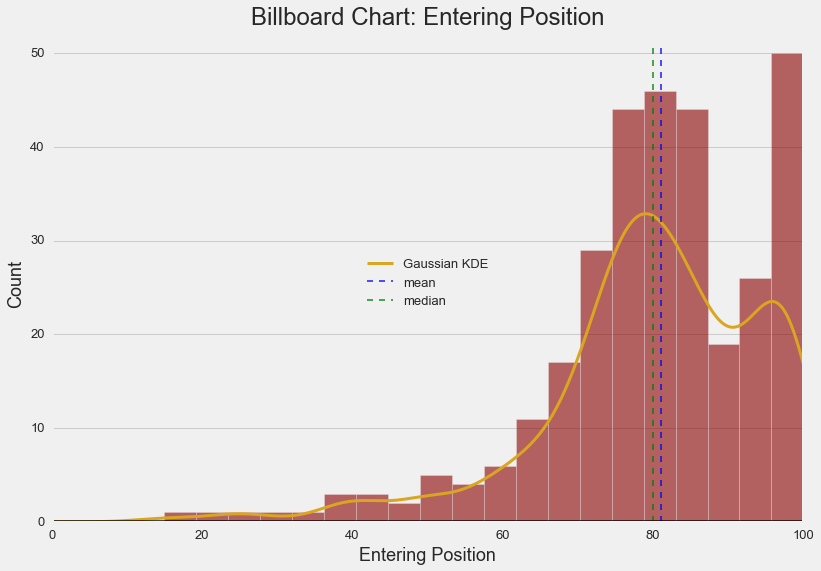

In [23]:
## Plot a histogram of entering chart position 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

density = gaussian_kde(music['entering_position'])
xs = np.linspace(0, 100, 1000)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs)*1000, linewidth = 3.0, label = 'Gaussian KDE', color = 'goldenrod')

music_hist = plt.hist(music['entering_position'], color = 'darkred', bins = 20, alpha = 0.6)

plt.axvline(music['entering_position'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['entering_position'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Entering Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count', fontsize = 18)
plt.yticks(range(0, 60, 10), fontsize = 13)
plt.ylim([0, 51])

# x label
plt.xlabel('Entering Position', fontsize = 18)
plt.xticks(range(0, 120, 20), fontsize = 13)
plt.xlim([0, 100])

# legend
plt.legend(loc='center', fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black', alpha = 0.7)

plt.show()

Looks like there's a little bump around 40, maybe for the Top 40 list.  The bottom end might be bimodal because songs that have been around for a while -- but less than 20 weeks! -- slide lower while fresh songs debut a little higher.

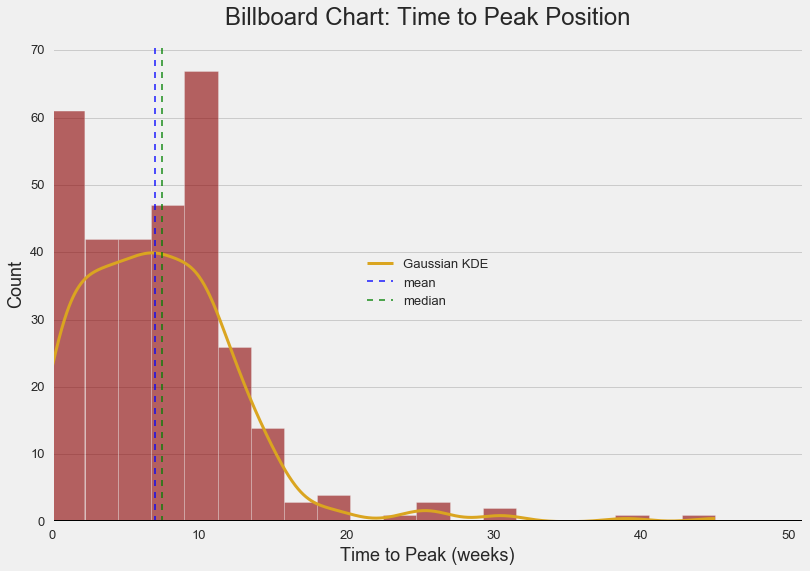

In [24]:
## Plot a histogram of time to peak chart position 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

density = gaussian_kde(music['weeks_to_peak'])
xs = np.linspace(music['weeks_to_peak'].min(), music['weeks_to_peak'].max(), 1000)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs)*1000/1.8, linewidth = 3.0, label = 'Gaussian KDE', color = 'goldenrod')


music_hist = plt.hist(music['weeks_to_peak'], color = 'darkred', bins = 20, alpha = 0.6)

plt.axvline(music['weeks_to_peak'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['weeks_to_peak'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Time to Peak Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count', fontsize = 18)
plt.ylim([0, 71])
plt.yticks(range(0, 80, 10), fontsize = 13)

# x label
plt.xlabel('Time to Peak (weeks)', fontsize = 18)
plt.xlim([0, 51])
plt.xticks(range(0, 60, 10), fontsize = 13)

# legend
plt.legend(loc='center', fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black')

plt.show()

This looks somewhat normally distributed but the peak is broad.

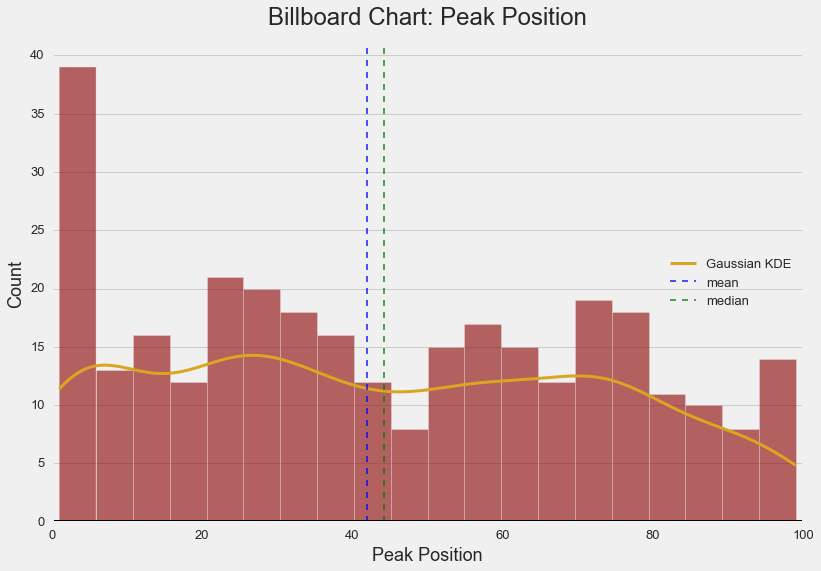

In [25]:
## Plot a histogram of peak chart position 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

density = gaussian_kde(music['peak_position'])
xs = np.linspace(music['peak_position'].min(), music['peak_position'].max(), 1000)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs)*10000/8, linewidth = 3.0, label = 'Gaussian KDE', color = 'goldenrod')


music_hist = plt.hist(music['peak_position'], color = 'darkred', bins = 20, alpha = 0.6)

plt.axvline(music['peak_position'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['peak_position'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Peak Position', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count', fontsize = 18)
plt.ylim([0, 41])
plt.yticks(range(0, 45, 5), fontsize = 13)

# x label
plt.xlabel('Peak Position', fontsize = 18)
#plt.xlim([0, 55])
plt.xticks(range(0, 120, 20), fontsize = 13)

# legend
plt.legend(loc='center right', fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black')

plt.show()

This histogram is all over the place!  Definitely not normally distributed; curious what makes it look this way.

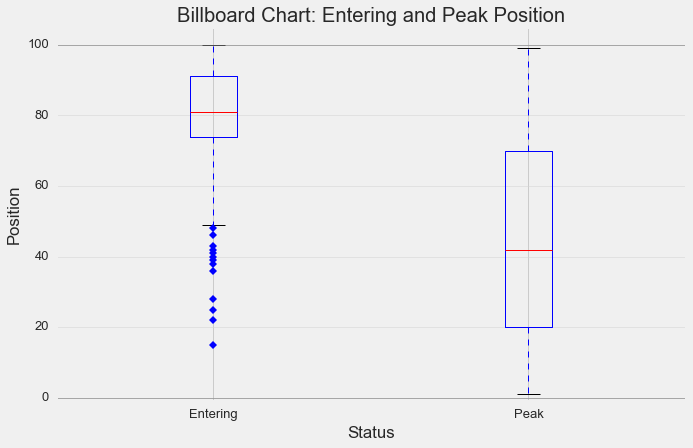

In [26]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(10, 8))

plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

data = [music['entering_position'], music['peak_position']]

bp = plt.boxplot(data, 0, 'gD', vert=1, whis=1.5)

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Entering and Peak Position')
ax1.set_xlabel('Status')
ax1.set_ylabel('Position')

# Set the axes ranges and axes labels
numBoxes = 2
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-1, 105)
xtickNames = plt.setp(ax1, xticklabels = ['Entering', 'Peak'])
plt.setp(xtickNames, fontsize=13)
ytickNames = plt.setp(ax1, yticklabels = range(-20, 120, 20)) ## not sure why 0 not working
plt.setp(ytickNames, fontsize=13)

plt.axhline(0, alpha = 0.6, color = 'grey', lw = 1)
plt.axhline(100, alpha = 0.6, color = 'grey', lw = 1)

del data 

plt.show()

These box plots seem to suggest that songs tend to enter the Top 100 chart lower than they peak.

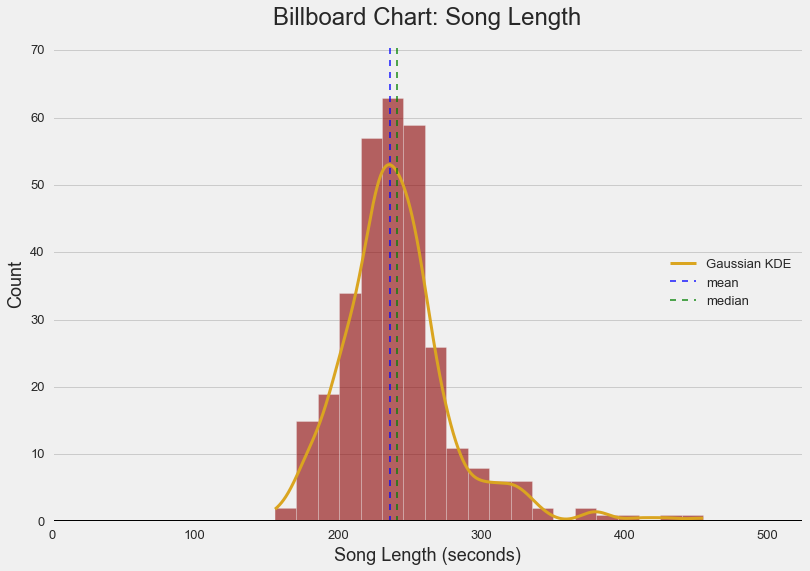

In [27]:
## Plot a histogram of song length 
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

density = gaussian_kde(music['time'])
xs = np.linspace(music['time'].min(), music['time'].max(), 1000)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs)*10000/2.5, linewidth = 3.0, label = 'Gaussian KDE', color = 'goldenrod')


plt.hist(music['time'], color = 'darkred', bins = 20, alpha = 0.6)

plt.axvline(music['time'].median(), color='blue', linestyle='dashed', \
            linewidth=1.5, label = 'mean', alpha = 0.9)

plt.axvline(music['time'].mean(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'median', alpha = 0.9)

plt.title('Billboard Chart: Song Length', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Count', fontsize = 18)
plt.ylim([0, 71])
plt.yticks(range(0, 80, 10), fontsize = 13)

# x label
plt.xlabel('Song Length (seconds)', fontsize = 18)
plt.xlim([0, 525])
plt.xticks(range(0, 600, 100), fontsize = 13)

# legend
plt.legend(loc='center right', fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.axhline(0, color='black')

plt.show()

This one, however, definitely looks normal with a right skew.  From some box plots below, we see that the bump to the right of the mean is likely due to rap, rock, country, and rock'n'roll.

In [28]:
## These are all songs taking longer than 150 days to reach peak chart position
music[music['weeks_to_peak'] > 20][['artist', 'track', 'genre', 'weeks_to_peak']]\
        .sort_values(by = 'weeks_to_peak', ascending = False)

,artist,track,genre,weeks_to_peak
46,Creed,Higher,Rock'n'roll,45.0
9,Lonestar,Amazed,Country,39.0
24,3 Doors Down,Kryptonite,Rock,31.0
157,Amber,Sexual (Li Da Di),Rock,30.0
13,Creed,With Arms Wide Open,Rock'n'roll,26.0
28,Joe,I Wanna Know,Rock'n'roll,26.0
12,Vertical Horizon,Everything You Want,Rock'n'roll,25.0
17,Faith Hill,Breathe,Rap,24.0


Ooooh, my favorites.

In [29]:
## These are all songs entering the chart at position 30 or better
music[music['entering_position'] < 30][['artist', 'track', 'genre', 'entering_position']]

,artist,track,genre,entering_position
1,Santana,"Maria, Maria",Rock,15.0
45,Pink,There U Go,Rock,25.0
80,Hanson,This Time Around,Country,22.0
114,Mariah Carey,Crybaby,Rock,28.0


Create a genre-color dictionary and a list of all genres:

In [30]:
genre_colors = {
    'Rock' : 'Red', 
    'Rock\'n\'roll' : 'Black',
    'Country' : 'Orange', 
    'Rap' : 'Yellow', 
    'R&B' : 'Green', 
    'Electronica' : 'Violet', 
    'Latin' : 'Indigo', 
    'Pop' : 'Blue'}

Define a function to jitter plotted points:

In [31]:
def rand_jitter(arr):
    disp = 0.003*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * disp

Make a column for plot point areas proportional to chart position (larger area --> more favorable position):

In [32]:
music.loc[:, 'peak_area'] = \
    MinMaxScaler([10, 150]).fit_transform(-1*music.loc[:, 'peak_position'].reshape(-1,1))

Plot time to peak versus song length, with color by genre:

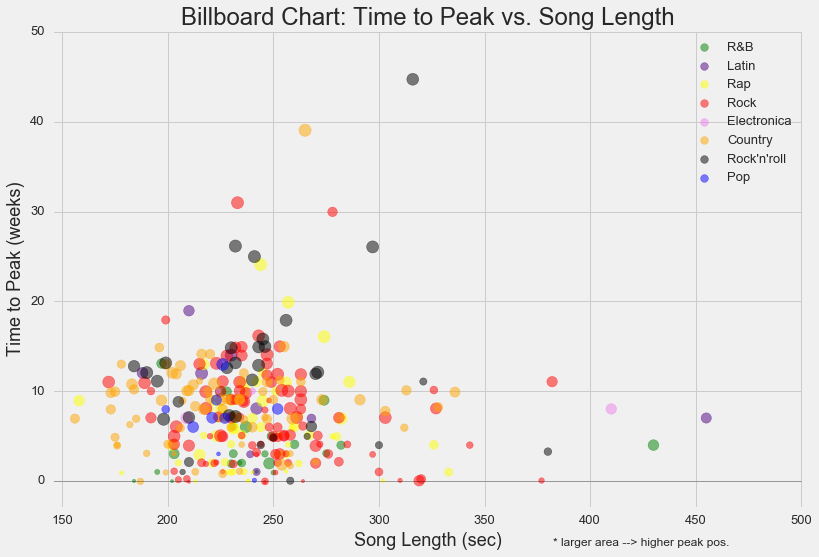

In [33]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in genre_colors.keys():
    y = music[music['genre'] == i]
    plt.scatter(y['time'], rand_jitter(y['weeks_to_peak']), \
                color = genre_colors[i], alpha = 0.5, s = y['peak_area'], label = i)

plt.title('Billboard Chart: Time to Peak vs. Song Length', fontsize = 24)

# y label
plt.ylabel('Time to Peak (weeks)', fontsize = 18)
plt.ylim([-3, 50.25])
plt.yticks(range(0, 60, 10), fontsize = 13)

# x label
plt.xlabel('Song Length (sec)', fontsize = 18)
plt.xlim([145, 501])
plt.xticks(range(150, 550, 50), fontsize = 13)
    
plt.axhline(0, color='black', linewidth = 0.5, alpha = 0.5)
plt.axvline(0, color='black')

lgnd = plt.legend(loc='upper right', fontsize = 13)

for lil in range(0, len(genre_colors.keys())):
    lgnd.legendHandles[lil]._sizes = [60]

plt.annotate('* larger area --> higher peak pos.', (1,0), (-250, -30), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

plt.show()

Country songs are short!

Make a column for plot point areas proportional to song length (larger area --> longer song):

In [34]:
music.loc[:, 'time_area'] = \
        MinMaxScaler([10, 250]).fit_transform(music.loc[:, 'time'].reshape(-1, 1))

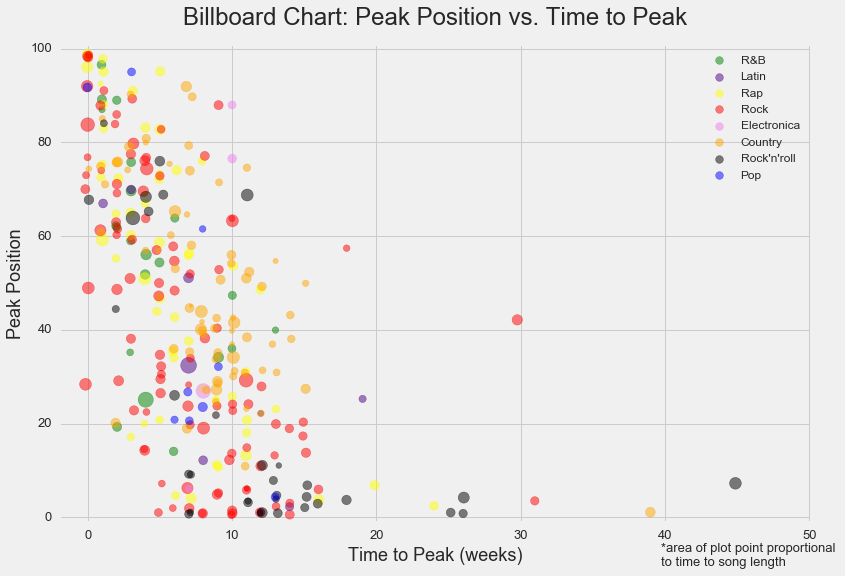

In [35]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in genre_colors.keys():
    y = music[music['genre'] == i]
    plt.scatter(rand_jitter(y['weeks_to_peak']), rand_jitter(y['peak_position']), \
                color = genre_colors[i], alpha = 0.5, s = y['time_area'], label = i)

plt.title('Billboard Chart: Peak Position vs. Time to Peak', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Peak Position', fontsize = 18)
plt.ylim([-1, 101])
plt.yticks(fontsize = 13)

# x label
plt.xlabel('Time to Peak (weeks)', fontsize = 18)
plt.xlim([-2, 50.09])
plt.xticks(fontsize = 13)

lgnd = plt.legend(loc='upper right', fontsize = 12, scatterpoints = 1)

for lil in range(0, len(genre_colors.keys())):
    lgnd.legendHandles[lil]._sizes = [60]

plt.annotate('*area of plot point proportional \nto time to song length', (1,0), \
             (-150, -20), xycoords='axes fraction', textcoords='offset points', \
             va='top', fontsize = 13)

plt.show()

Seems like not many songs take more than 20 weeks to peak; [investigating](http://www.billboard.com/biz/billboard-charts-legend), we find: 

_"RECURRENT RULES_ 
 
_Descending songs are removed from the Billboard Hot 100 and Hot 100 Airplay simultaneously after 20 weeks on the Billboard Hot 100 and if ranking below No. 50."_

Let's just take out any songs that took longer than 20 weeks to peak, and say that our results only apply to those that look less time:

In [36]:
music = music[music['weeks_to_peak'] <= 20]

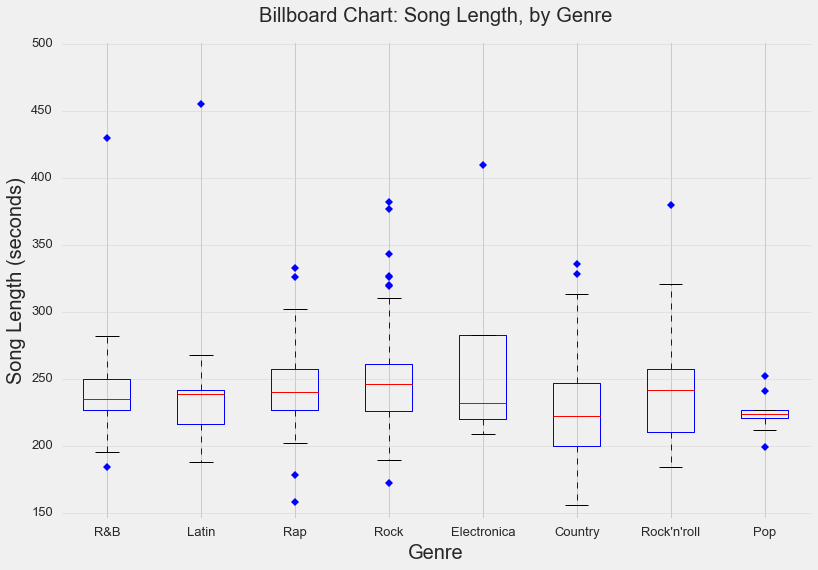

In [37]:
## SONG LENGTH
## cleaned: no

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))

data = []

for lil_genre in genre_colors.keys():
    data.append(music.loc[music['genre'] == lil_genre, 'time'])

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Song Length, by Genre', y =1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Song Length (seconds)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(145, 502)
xtickNames = plt.setp(ax1, xticklabels = genre_colors.keys())
plt.setp(xtickNames, fontsize = 13)
ytickNames = plt.setp(ax1, yticklabels = range(100, 550, 50))
plt.setp(ytickNames, fontsize = 13)

del data

plt.show()

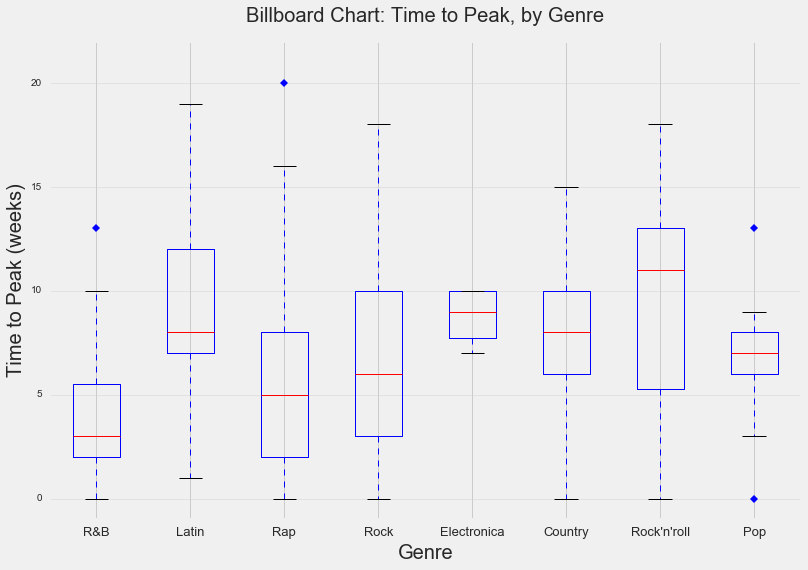

In [38]:
## WEEKS TO PEAK
## cleaned: no

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))

data = []

for lil_genre in genre_colors.keys():
    data.append(music.loc[music['genre'] == lil_genre, 'weeks_to_peak'])

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Time to Peak, by Genre', y =1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Time to Peak (weeks)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-1, 22)
xtickNames = plt.setp(ax1, xticklabels = genre_colors.keys())
plt.setp(xtickNames, fontsize = 13)
#ytickNames = plt.setp(ax1, yticklabels = range(0, 30, 10))
plt.setp(ytickNames, fontsize=13)

del data

plt.show()

### Clean data:

Let's get rid of observations lying more than 3 standard deviations from the sample mean:

In [39]:
music = music[np.abs(music['time'] - music['time'].mean())<=(3*music['time'].std())]
music = music[np.abs(music['weeks_to_peak'] - \
                     music['weeks_to_peak'].mean())<=(3*music['weeks_to_peak'].std())]  

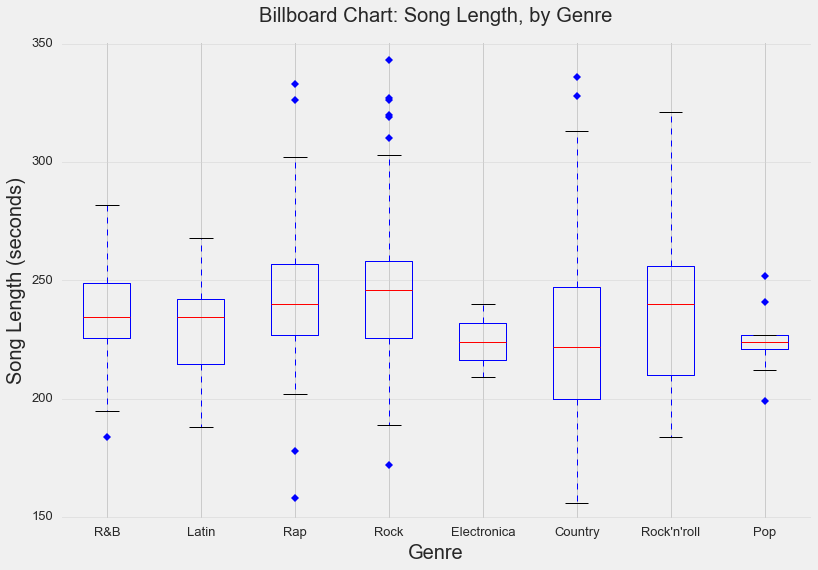

In [40]:
## SONG LENGTH
## cleaned: yes

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))

data = []

for lil_genre in genre_colors.keys():
    data.append(music.loc[music['genre'] == lil_genre, 'time'])
    
plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Song Length, by Genre', y =1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Song Length (seconds)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(149, 351)
xtickNames = plt.setp(ax1, xticklabels = genre_colors.keys())
plt.setp(xtickNames, fontsize = 13)
ytickNames = plt.setp(ax1, yticklabels = range(100, 400, 50))
plt.setp(ytickNames, fontsize = 13)

del data

plt.show()

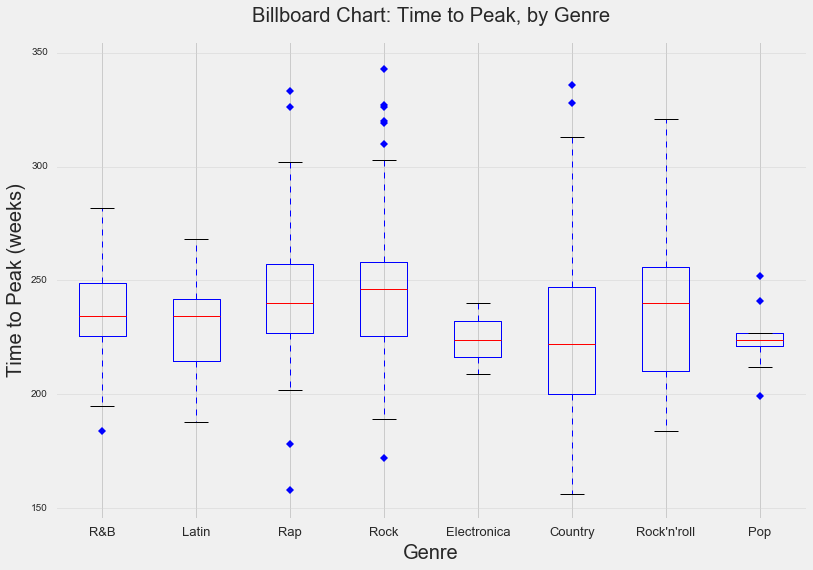

In [41]:
## WEEKS TO PEAK
## cleaned: yes

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))

data = []

for lil_genre in genre_colors.keys():
    data.append(music.loc[music['genre'] == lil_genre, 'time'])

plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Billboard Chart: Time to Peak, by Genre', y = 1.03)
ax1.set_xlabel('Genre', fontsize = 20)
ax1.set_ylabel('Time to Peak (weeks)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = len(set(music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(145, 355)
xtickNames = plt.setp(ax1, xticklabels = genre_colors.keys())
plt.setp(xtickNames, fontsize = 13)
#ytickNames = plt.setp(ax1, yticklabels = range(-5, 40, 5))
plt.setp(ytickNames, fontsize=13)

del data

plt.show()

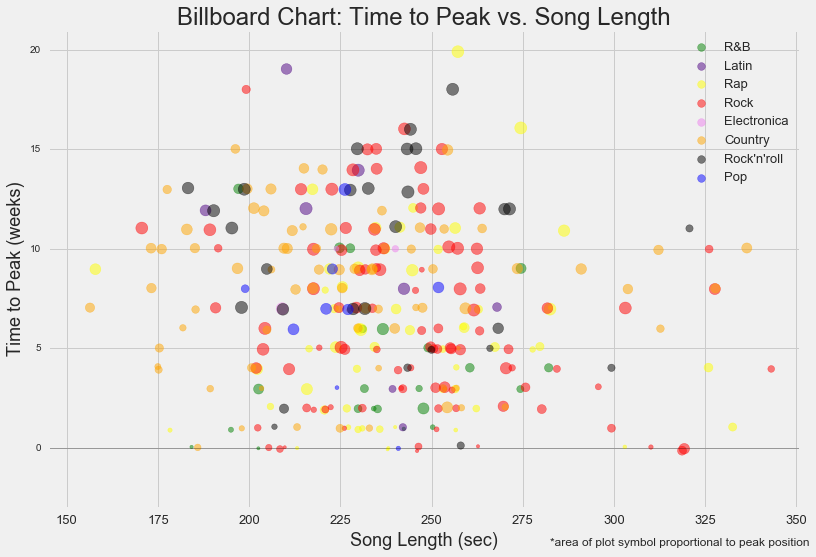

In [42]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in genre_colors.keys():
    y = music[music['genre'] == i]
    plt.scatter(rand_jitter(y['time']), rand_jitter(y['weeks_to_peak']), \
                color = genre_colors[i], alpha = 0.5, s = y['peak_area'], label = i)

plt.title('Billboard Chart: Time to Peak vs. Song Length', fontsize = 24)

# y label
plt.ylabel('Time to Peak (weeks)', fontsize = 18)
plt.ylim([-3, 21])
#plt.yticks(range(0, 60, 10), fontsize = 13)

# x label
plt.xlabel('Song Length (sec)', fontsize = 18)
plt.xlim([145, 351])
plt.xticks(range(150, 375, 25), fontsize = 13)

lgnd = plt.legend(loc='upper right', fontsize = 13, scatterpoints = 1)

for lil in range(0, len(genre_colors.keys())):
    lgnd.legendHandles[lil]._sizes = [60]
    
plt.axhline(0, color='black', linewidth = 0.5, alpha = 0.5)

plt.annotate('*area of plot symbol proportional to peak position', (1,0), (-250, -30), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

plt.show()

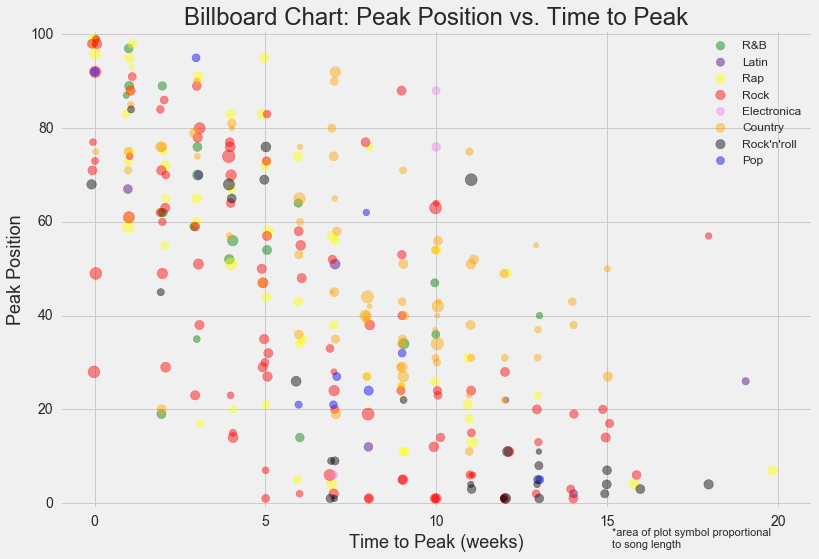

In [43]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in genre_colors.keys():
    y = music[music['genre'] == i]
    plt.scatter(rand_jitter(y['weeks_to_peak']), \
                y['peak_position'], color = genre_colors[i], \
                alpha = 0.45, s = y['time_area'], label = i)

plt.title('Billboard Chart: Peak Position vs. Time to Peak', fontsize = 24)

# y label
plt.ylabel('Peak Position', fontsize = 18)
plt.ylim([-1, 101])
plt.yticks(range(0, 120, 20), fontsize = 14)

# x label
plt.xlabel('Time to Peak (weeks)', fontsize = 18)
plt.xlim([-1, 21])
plt.xticks(range(0, 25, 5), fontsize = 14)

plt.legend(loc='upper right', fontsize = 12, scatterpoints = 1)

for lil in range(0, len(genre_colors.keys())):
    lgnd.legendHandles[lil]._sizes = [60]

plt.annotate('*area of plot symbol proportional \nto song length', \
             (1,0), (-200, -20), xycoords='axes fraction', textcoords='offset points', \
             va='top', fontsize = 11)

plt.show()

Lots of black at the top of the chart; let's check that out:

In [44]:
music.loc[music['genre'] == 'Rock\'n\'roll', 'artist'].value_counts()

Sisqo                    2
Christina Aguilera       2
N'Sync                   2
Samantha Mumba           1
Macy Gray                1
Mya                      1
SoulDecision             1
Red Hot Chili Peppers    1
Smash Mouth              1
Britney Spears           1
Nine Days                1
Limp Bizkit              1
Third Eye Blind          1
The Backstreet Boys      1
Mary J. Blige            1
Avant                    1
Whitney Houston          1
Sonique                  1
LFO                      1
Vitamin C                1
Destiny's Child          1
Everclear                1
Aaliyah                  1
Next                     1
Metallica                1
Pink                     1
Name: artist, dtype: int64

Not sure who categorized these songs, but a lot of these don't look like 'Rock'n'roll' artists.  We'll ignore this, for now, and do a hypothesis test that doesn't consider genre... onward!

In [45]:
music.reset_index(drop = False, inplace = True)

## Hypothesis Testing

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We hypothesize that there is a linear relationship at a 0.05 significance level between the amount of time it takes a song to reach its peak position on the Billboard chart and the peak position itself.  We will test against the null hypothesis that the slope of the regression line is equal to zero.

For regression line: 

        y = B0 + Β1x

H0: Β1 = 0 

Ha: Β1 ≠ 0 

In [46]:
scaled = pd.DataFrame(StandardScaler().\
                      fit_transform(music[['weeks_to_peak', 'peak_position']]),\
                      columns = ['weeks_to_peak', 'peak_position'])

X = pd.DataFrame(sm.add_constant(scaled.drop(['peak_position'], axis = 1)))
X.columns = ['constant', 'weeks_to_peak']

scaled[['genre', 'time_area']] = music[['genre', 'time_area']]
scaled

y = scaled['peak_position']

ols = sm.OLS(y, X)

ols_result = ols.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          peak_position   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     229.1
Date:                Wed, 22 Mar 2017   Prob (F-statistic):           8.63e-39
Time:                        02:00:00   Log-Likelihood:                -340.13
No. Observations:                 300   AIC:                             684.3
Df Residuals:                     298   BIC:                             691.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
constant      -1.388e-17      0.044  -3.19e-16      1.000        -0.086     0.086
weeks_to_peak    -0.6593      0.044    -15.137      0.000        -0.745    -0.574
==============================================================================
Omnibus:                        1.338   Durbin-Watson:                   0.846
Prob(Omnibus):                  0.512   Jarque-Bera (JB):                1.367
Skew:                          -0.095   Prob(JB):                        0.505
Kurtosis:                       2.730   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
print 'Parameters: '
print ols_result.params, '\n'
print 'R^2: ' 
print ols_result.rsquared

Parameters: 
constant        -1.387779e-17
weeks_to_peak   -6.593000e-01
dtype: float64 

R^2: 
0.434676481779


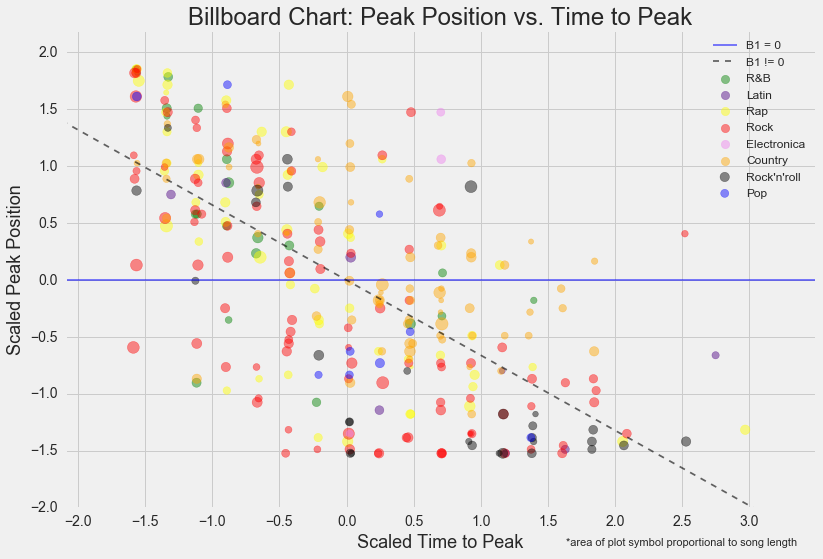

In [48]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in genre_colors.keys():
    y = scaled[scaled['genre'] == i] 
    plt.scatter(rand_jitter(y['weeks_to_peak']), y['peak_position'], \
                color = genre_colors[i], alpha = 0.45, s = y['time_area'], label = i)

x = np.arange(-20, 20, 0.5)
m = round(ols_result.params[1], 2)
b = ols_result.params[0]

plt.axhline(scaled['peak_position'].mean(), alpha = 0.5, linewidth = 2, label = 'B1 = 0')
plt.plot(x, m*x + b, '--', linewidth = 1.75, color = 'black', alpha = 0.6, label = 'B1 != 0')
plt.title('Billboard Chart: Peak Position vs. Time to Peak', fontsize = 24)


plt.ylabel('Scaled Peak Position', fontsize = 18)
plt.ylim([-2, 2.2])
plt.yticks(np.arange(-2, 2.2, 0.5), fontsize = 14)

plt.xlabel('Scaled Time to Peak', fontsize = 18)
plt.xlim([-2.1, 3.5])
plt.xticks(np.arange(-2.0, 3.50, 0.5), fontsize = 14)

lgnd = plt.legend(loc='upper right', fontsize = 12)

for lil in range(0, len(genre_colors.keys())):
    lgnd.legendHandles[lil]._sizes = [70]

plt.annotate('*area of plot symbol proportional to song length', \
             (1,0), (-250, -30), xycoords='axes fraction', textcoords='offset points', \
             va='top', fontsize = 11)

plt.show()

### Conclusion

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Thus, since p-value << 0.05 for the coefficient, we reject the null hypothesis that there is no linear relationship between the amount of time it takes a song to peak on the Billboard chart and the final position.  It appears as though the longer a song takes, the more favorable the peak position is.  (NB this only applies to songs that take less than 20 weeks to reach peak position, because of special Billboard policy referenced above.)